## Семинар 5: "Улучшение сходимости нейросетей"

ФИО:Курбанов Ринат Фирдусович

In [1]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from train_utils import train
%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

9920512it [00:09, 1074778.97it/s]                                                                                      


Extracting .\MNIST\raw\train-images-idx3-ubyte.gz to .\MNIST\raw


32768it [00:00, 79988.91it/s]                                                                                          


Extracting .\MNIST\raw\train-labels-idx1-ubyte.gz to .\MNIST\raw


1654784it [00:03, 508002.10it/s]                                                                                       


Extracting .\MNIST\raw\t10k-images-idx3-ubyte.gz to .\MNIST\raw


8192it [00:00, 32394.92it/s]                                                                                           


Extracting .\MNIST\raw\t10k-labels-idx1-ubyte.gz to .\MNIST\raw
Processing...
Done!


In [3]:
images_train, labels_train = next(iter(train_loader))

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

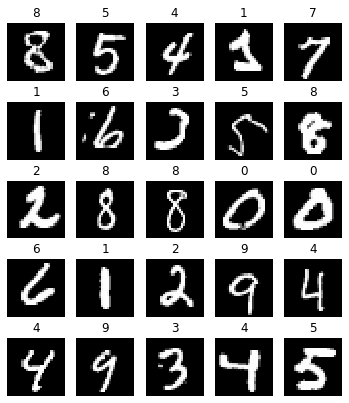

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [6]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

    
# пример:
layer = nn.Linear(28*28, 10)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
init_layer(layer, 0.0, 0.1) # сюда надо подставить другие параметры

In [7]:
def make_linear(in_dim, out_dim, init_func):
    layer = nn.Linear(in_dim, out_dim)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_func(layer)
    
    return layer

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [45]:
def dumb_init(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=1)

def xavier_init(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    
    d = 2 / (weight.size()[0] + weight.size()[1])
    weight.normal_(mean=0, std=np.sqrt(d))
    
def xavier_init_uni(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    
    r = np.sqrt(6 / (weight.size()[0] + weight.size()[1]))
    weight.uniform_(-r, r)

def xe_init(layer,output_size):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=np.sqrt(2/weight.size()[0]))
    layers = []

<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [39]:
def new_linear_layer(input_size, output_size, mean, std, distr='normal'):
    layer = nn.Linear(input_size, output_size)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    if distr == 'normal':
        init_layer(layer, 0, 1)
    elif distr == 'xavier':
        xavier_init(layer)
    elif distr == 'xavier_uni':
        xavier_init_uni(layer)
    elif distr == 'he':
        xe_init(layer, output_size)
    return layer

In [28]:
def test_init(distr='normal'):
    layers = []
    mean = 0
    std = 0.1
    layers.append(new_linear_layer(784, 500, mean=0, std=np.sqrt(2./500), distr=distr))
    layers.append(nn.ReLU())
    
    for i in range(10):
        layers.append(new_linear_layer(500, 500, mean=0, std=np.sqrt(2./500), distr=distr))
        layers.append(nn.ReLU())
        
    layers.append(new_linear_layer(500, 10, mean=0, std=np.sqrt(2./10),  distr=distr))
    layers.append(nn.LogSoftmax())
    network = nn.Sequential(*layers)
    n_objects = 100
    X = Variable(images_train[:n_objects], requires_grad=False).view(n_objects, -1)
    y = Variable(labels_train[:n_objects], requires_grad=False)
    activations = network(X)
    loss_fn = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
    loss = loss_fn(activations, y)
    loss.backward()

In [29]:
test_init('normal')

forward 0.9748889207839966
forward 16.253902435302734
forward 263.5762939453125
forward 4404.8642578125
forward 70368.4375
forward 1101392.625
forward 17122396.0
forward 272149984.0
forward 4060818432.0
forward 60208152576.0
forward 989713858560.0
forward 15642547716096.0
backward 0.23981468379497528
backward 0.4920850098133087
backward 7.22713565826416
backward 101.64096069335938
backward 1458.5882568359375
backward 22680.890625
backward 323721.84375
backward 4498532.5
backward 64116444.0
backward 865147712.0
backward 11622554624.0
backward 159744606208.0


In [30]:
test_init('xavier')

forward 0.9748889207839966
forward 0.6522091627120972
forward 0.46438491344451904
forward 0.32424429059028625
forward 0.2388266623020172
forward 0.17743755877017975
forward 0.12266167253255844
forward 0.08064740896224976
forward 0.05332772433757782
forward 0.03571666404604912
forward 0.025574592873454094
forward 0.018399085849523544
backward 0.05879862979054451
backward 0.00845287460833788
backward 0.005705221556127071
backward 0.0034901543986052275
backward 0.0023978804238140583
backward 0.0016763036837801337
backward 0.0010780413867905736
backward 0.000795530853793025
backward 0.0005333708832040429
backward 0.0003706356801558286
backward 0.00026419918867759407
backward 0.0001824481732910499


In [31]:
test_init('xavier_uni')

forward 0.9748889207839966
forward 0.6133791208267212
forward 0.44237545132637024
forward 0.3213130831718445
forward 0.23154965043067932
forward 0.15979552268981934
forward 0.10321603715419769
forward 0.07497982680797577
forward 0.05578618124127388
forward 0.0394771434366703
forward 0.027546951547265053
forward 0.01996861770749092
backward 0.056628115475177765
backward 0.006989344023168087
backward 0.004867213312536478
backward 0.003415671642869711
backward 0.0024058199487626553
backward 0.0017126157181337476
backward 0.001040761242620647
backward 0.0007044029189273715
backward 0.0004973820177838206
backward 0.00031505306833423674
backward 0.00022210519819054753
backward 0.00015074628754518926


In [46]:
test_init('he')

forward 0.9748889207839966
forward 1.0261714458465576
forward 1.0449010133743286
forward 1.009427785873413
forward 1.0629135370254517
forward 1.1550809144973755
forward 1.0827184915542603
forward 1.0200904607772827
forward 1.0064889192581177
forward 1.0152393579483032
forward 1.0478912591934204
forward 1.0104343891143799
backward 0.3172568082809448
backward 0.2674503028392792
backward 0.23421986401081085
backward 0.21953962743282318
backward 0.1904858946800232
backward 0.1770809143781662
backward 0.16284164786338806
backward 0.15554463863372803
backward 0.1357700377702713
backward 0.1263829469680786
backward 0.11233744025230408
backward 0.09869220107793808


<i> 1.4 Сделайте выводы по первой части </i>

интересный результат для xe 

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [11]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class Flatten(torch.nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()        
        self.lin = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):
        mask = torch.ones_like(self.lin.weight) * self.p
        
        if self.training:
            mask = torch.ones_like(self.lin.weight) * self.p
            mask.bernoulli_()
            
        mask.detach_()

        output = torch.mm(x, (self.lin.weight*mask).transpose(0, 1))+self.lin.bias
        return output

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Dropout между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

In [12]:
net = [Flatten()]

sizes = [28**2, 200, 200]
for in_dim, out_dim in zip(sizes, sizes[1:]):    
    #net.append(DropConnect(in_dim, out_dim))
    net.append(nn.Linear(in_dim, out_dim))
    net.append(nn.Dropout(0.5))
    net.append(nn.ReLU())
    
net.append(nn.Linear(sizes[-1], 10))
net.append(nn.LogSoftmax(1))
net = nn.Sequential(*net)

Epoch 4... (Train/Test) NLL: 0.580/0.299	Accuracy: 0.854/0.930


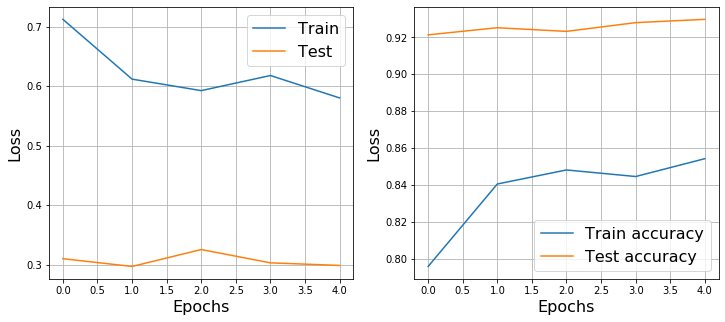

([0.7125355277234303,
  0.6119777055691554,
  0.5926778649470446,
  0.6180741975683648,
  0.5803634125286582],
 [0.3099656923662258,
  0.29693873905682866,
  0.3253728688894948,
  0.3029778325293638,
  0.29865438415657114],
 [0.7956978, 0.84044063, 0.8480588, 0.84449404, 0.8541778],
 [0.9213805, 0.92523736, 0.9232595, 0.92800635, 0.9297864])

In [13]:
train(net, train_loader, test_loader, 5, 0.01)

<i> 2.3 Сделайте выводы по третьей части. Отобразите кривые обучения на одном графике </i>

In [16]:
net = [Flatten()]

sizes = [28**2, 200, 200]
for in_dim, out_dim in zip(sizes, sizes[1:]):    
    net.append(DropConnect(in_dim, out_dim))
    #net.append(nn.Linear(in_dim, out_dim))
    #net.append(nn.Dropout(0.5))
    net.append(nn.ReLU())
    
net.append(nn.Linear(sizes[-1], 10))
net.append(nn.LogSoftmax(1))
net = nn.Sequential(*net)

Epoch 4... (Train/Test) NLL: 0.257/0.184	Accuracy: 0.931/0.951


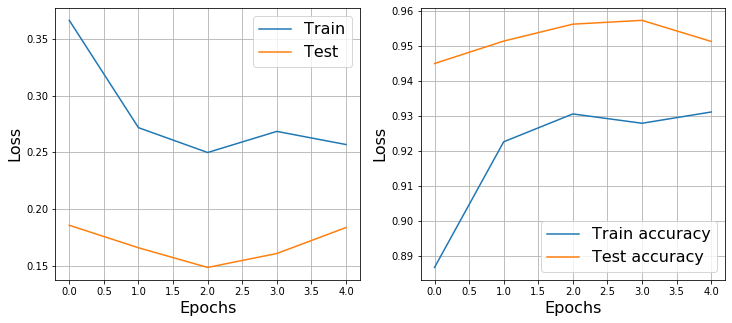

([0.36666177027324626,
  0.27183397112688273,
  0.2498711822256605,
  0.2685344152883299,
  0.25692409251544523],
 [0.18557260878667048,
  0.16568663357933866,
  0.14830204764310317,
  0.16062622220267223,
  0.18354535626271104],
 [0.8866383, 0.9226135, 0.930587, 0.9279162, 0.9311423],
 [0.94501585, 0.95144385, 0.9562895, 0.9573774, 0.9513449])

In [17]:
train(net, train_loader, test_loader, 5, 0.01)

ну второй вариант привлекательнее выгляждит

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [17]:
# полезные функции: .std(dim), .mean(dim)
class LayerNormalization(nn.Module):
    def __init__(self, input_dim):
        super(LayerNormalization, self).__init__()
        self.gamma = nn.Parameter(torch.FloatTensor(input_dim).fill_(1), requires_grad=True)
        self.beta = nn.Parameter(torch.FloatTensor(input_dim).fill_(0.1), requires_grad=True)
        
    def forward(self, x, eps=1e-8,):
        output = (x - x.mean(dim=1).view(-1, 1)) / (x.std(dim=1).view(-1, 1)+eps)*self.gamma+self.beta
        return output

$$output = \frac{x - \mathrm{E}[x]}{\sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta$$

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Batch normalization между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

In [14]:
##### YOUR CODE HERE #####
#bath normalization
network = nn.Sequential(Flatten(),
                        nn.Linear(784, 200),
                        nn.BatchNorm1d(200),
                        nn.ReLU(),
                        nn.Linear(200, 200),
                        nn.BatchNorm1d(200),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax(1))

network

Sequential(
  (0): Flatten()
  (1): Linear(in_features=784, out_features=200, bias=True)
  (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Linear(in_features=200, out_features=200, bias=True)
  (5): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): Linear(in_features=200, out_features=10, bias=True)
  (8): LogSoftmax()
)

Epoch 4... (Train/Test) NLL: 0.042/0.080	Accuracy: 0.986/0.976


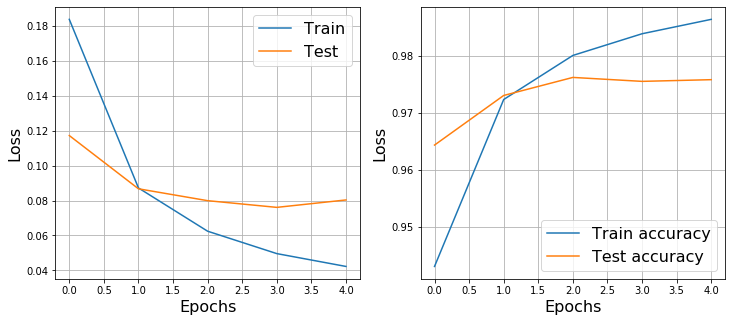

([0.183981858455995,
  0.08724184376177693,
  0.062427010880644195,
  0.04957941900005441,
  0.04221415818075159],
 [0.11731881552222598,
  0.08676285669207573,
  0.07994986447370081,
  0.07610764522993306,
  0.08036521153783874],
 [0.94310814, 0.9723925, 0.98012173, 0.9839252, 0.9864517],
 [0.96439874, 0.97310126, 0.97626585, 0.9755736, 0.97587025])

In [15]:
train(network, train_loader, test_loader, 5, 0.01)

Epoch 4... (Train/Test) NLL: 0.050/0.076	Accuracy: 0.984/0.978


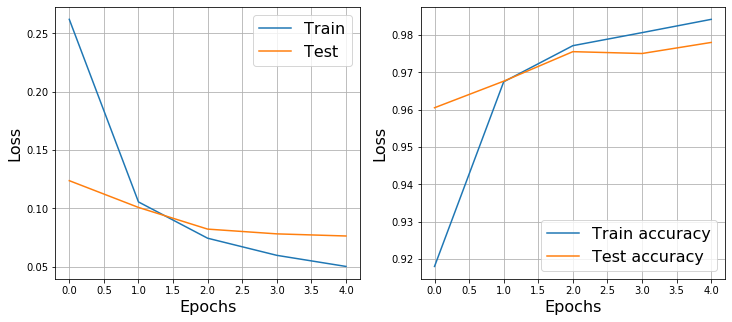

([0.2621185484248946,
  0.10558542828840106,
  0.0744623993255341,
  0.05978428977412551,
  0.050262717188580205],
 [0.12380365744421754,
  0.10086833169282991,
  0.08227319930550418,
  0.07819766766403484,
  0.0763730169156024],
 [0.9180159, 0.9675007, 0.9771788, 0.98067147, 0.98423064],
 [0.9605419, 0.96766216, 0.9755736, 0.9750791, 0.9780459])

In [18]:
network = nn.Sequential(Flatten(),
                        nn.Linear(784, 200),
                        LayerNormalization(200),
                        nn.ReLU(),
                        nn.Linear(200, 200),
                        LayerNormalization(200),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax(1))

train(network, train_loader, test_loader, 5, 0.01)

<i> 3.3 Сделайте выводы по третьей части </i>

Очень хороший результат, при этом почти одинаковый

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: